# Learning rate schedule

In [1]:
import os
import math

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import tensorflow.keras.losses as losses

def iou(y_true, y_pred):
    smooth = 0.
    
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    score = intersection / (union + smooth)
    
    return score

def dice_coef(y_true, y_pred):
    smooth = 0.
    
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)

    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 1.*losses.binary_crossentropy(y_true, y_pred) + 1.*dice_loss(y_true, y_pred)

    return loss

In [3]:
from tensorflow import keras
import albumentations as A
import cv2

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            # Declare an augmentation pipeline
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2),  
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask
        
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size,
                 mode='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        invalid_filnames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[-self.df['file_name'].isin(invalid_filnames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        start = idx * self.batch_size
        final = (idx + 1) * self.batch_size
        data = self.df.iloc[start:final]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(f'data/images/{file_name}.jpg') # f는 f-string 문자열 포매팅
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            mask = cv2.imread(f'data/annotations/trimaps/{file_name}.png',
                              cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.image_size, self.image_size))
            mask[mask != 1] = 0
            
            
            if self.mode == 'train':
#                 image = image.astype('uint8')
                image, mask = self.transform(image=image, mask=mask)
                
            image = image.astype('float32')
            image = image / 255.
            mask = mask.astype('float32')
#             label = int(r['id']) - 1
            
            batch_x.append(image)
            batch_y.append(mask)
        
        return batch_x, batch_y
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=8,
    image_size=128,
    shuffle=True
)
valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=8,
    image_size=128,
    shuffle=True
)

In [4]:
len(train_generator)

735

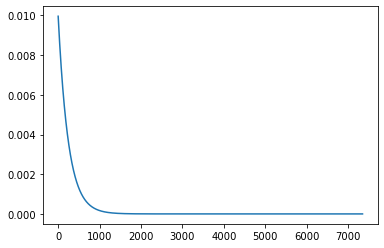

In [10]:
def decayed_learning_rate(step):
    initial_learning_rate = 0.01
    decay_rate = 0.96
#     decay_steps = 735 * 10
    decay_steps = 10
    return initial_learning_rate * decay_rate ** (step / decay_steps)

lrs = [decayed_learning_rate(i) for i in range(1, 735 * 10)]
plt.plot(lrs)

In [11]:
from tensorflow.keras import optimizers

lr_schedule = optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=10,
    decay_rate=0.96
)
optimizer = optimizers.Adam(lr_schedule)

In [12]:
# https://github.com/karolzak/keras-unet
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape=(128, 128, 3),
    use_batch_norm=True,
    upsample_mode='deconv',
    dropout_type='spatial',
    use_attention=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    num_layers=4,
    output_activation='sigmoid')

model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[iou])
model.summary()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm

 conv2d_transpose (Conv2DTransp  (None, 16, 16, 512)  2097664    ['batch_normalization_9[0][0]']  
 ose)                                                                                             
                                                                                                  
 conv2d_10 (Conv2D)             (None, 16, 16, 512)  262656      ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_11 (Conv2D)             (None, 16, 16, 512)  262656      ['conv2d_transpose[0][0]']       
                                                                                                  
 add (Add)                      (None, 16, 16, 512)  0           ['conv2d_10[0][0]',              
                                                                  'conv2d_11[0][0]']              
                                                                                                  
 activatio

 concatenate_2 (Concatenate)    (None, 64, 64, 256)  0           ['conv2d_transpose_2[0][0]',     
                                                                  'multiply_2[0][0]']             
                                                                                                  
 conv2d_23 (Conv2D)             (None, 64, 64, 128)  294912      ['concatenate_2[0][0]']          
                                                                                                  
 batch_normalization_14 (BatchN  (None, 64, 64, 128)  512        ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_24 (Conv2D)             (None, 64, 64, 128)  147456      ['batch_normalization_14[0][0]'] 
                                                                                                  
 batch_nor

In [13]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1,
)

Epoch 1/10
735/735 [==============================] - 990s 1s/step - loss: 0.8850 - iou: 0.4157 - val_loss: 0.6975 - val_iou: 0.5070
Epoch 2/10
735/735 [==============================] - 653s 890ms/step - loss: 0.7311 - iou: 0.4893 - val_loss: 0.6591 - val_iou: 0.5284
Epoch 3/10
735/735 [==============================] - 636s 863ms/step - loss: 0.7185 - iou: 0.4972 - val_loss: 0.6582 - val_iou: 0.5300
Epoch 4/10
735/735 [==============================] - 635s 862ms/step - loss: 0.7157 - iou: 0.4986 - val_loss: 0.6586 - val_iou: 0.5305
Epoch 5/10
735/735 [==============================] - 632s 860ms/step - loss: 0.7150 - iou: 0.4983 - val_loss: 0.6581 - val_iou: 0.5307
Epoch 6/10
735/735 [==============================] - 631s 859ms/step - loss: 0.7187 - iou: 0.4969 - val_loss: 0.6569 - val_iou: 0.5310
Epoch 7/10
735/735 [==============================] - 634s 863ms/step - loss: 0.7184 - iou: 0.4971 - val_loss: 0.6576 - val_iou: 0.5310
Epoch 8/10
735/735 [==============================]

NameError: name 'train_losses' is not defined

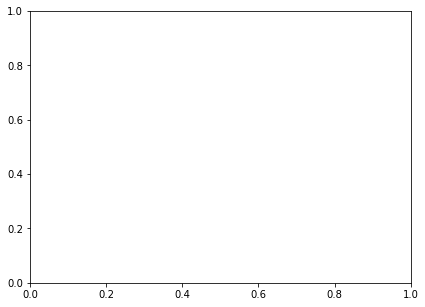

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses[:10], label='w/o scheduling')
plt.plot(history.history['loss'], label='scheduling')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Train Loss")

plt.subplot(1, 2, 2)
plt.plot(train_ious[:10], label='w/o scheduling')
plt.plot(history.history['iou'], label='scheduling')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('IoU')
plt.title("Train IoU")
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(valid_losses[:10], label='w/o scheduling')
plt.plot(history.history['val_loss'], label='scheduling')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Valid Loss")

plt.subplot(1, 2, 2)
plt.plot(valid_ious[:10], label='w/o scheduling')
plt.plot(history.history['val_iou'], label='scheduling')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('IoU')
plt.title("Valid IoU")
plt.show()